## Exercise 4: Manifold Learning


Import libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE as SKTSNE
from sklearn.preprocessing import LabelEncoder


## Utility functions

#### Hamming distance
The Hamming distance between two strings of equal length is the number of positions at which the corresponding characters are different.

In [15]:

def hamming_distance(seq1, seq2):
    """Compute Hamming distance between two equal-length strings."""
    if len(seq1) != len(seq2):
        print("Sequences are not of equal length")
    return sum(ch1 != ch2 for ch1, ch2 in zip(seq1, seq2))

# Tests

#seq1 = "GATTACA"
#seq2 = "GACTATA"
#print(hamming_distance(seq1, seq2))  

#seq1 = "11011101"
#seq2 = "10001001"
#print(hamming_distance(seq1, seq2))  


#### Distance matrix
 The function is designed to compute a pairwise distance matrix for a given list of sequences. Specifically, it calculates the Hamming distance between all pairs of sequences and stores these distances in a symmetric matrix.

In [3]:
def compute_distance_matrix(sequences):
    n = len(sequences)
    D = np.zeros((n, n))
    for i in range(n):
        for j in range(i+1, n):
            dist = hamming_distance(sequences[i], sequences[j])
            D[i, j] = dist
            D[j, i] = dist
    return D

The x2p function is essential for:Converting distances into meaningful probabilities, ensuring the probabilities match the user-defined perplexity, adapting to local density variations in the data and providing accurate input for the cost function that drives the optimization process.

In [4]:
def x2p(distances, perplexity=30.0, tol=1e-5):
    """
    Binary search for sigma to get P distribution for one row (fixed i) such that perplexity is correct.
    distances: distance vector for a single data point to all others.
    """
    # distances (1D): Distances from a point i to all others j
    # binary search over beta = 1/(2\sigma^2)
    beta = 1.0
    log_perp = np.log(perplexity)
    
    # Remove i-th distance
    mask = distances > 0
    def hp(beta_val):
        # Compute probabilities given beta
        P = np.exp(-distances[mask] * beta_val)
        sumP = np.sum(P)
        H = np.log(sumP) + beta_val * np.sum(distances[mask] * P) / sumP
        return H, P/sumP
    
    H, P = hp(beta)
    H_diff = H - log_perp
    # Binary search bounds
    beta_min, beta_max = -np.inf, np.inf
    tries = 50
    
    for _ in range(tries):
        if np.abs(H_diff) < tol:
            break
        if H_diff > 0:
            # need to decrease entropy => increase beta
            beta_min = beta if beta_min == -np.inf else beta_min
            if beta_max == np.inf:
                beta *= 2.
            else:
                beta = (beta + beta_max)/2.
        else:
            # need to increase entropy => decrease beta
            beta_max = beta if beta_max == np.inf else beta_max
            if beta_min == -np.inf:
                beta /= 2.
            else:
                beta = (beta + beta_min)/2.
        H, P = hp(beta)
        H_diff = H - log_perp
    result = np.zeros_like(distances)
    result[mask] = P
    return result


#### Compute high dimensional probability
The function calculates the high-dimensional probability matrix 
𝑃 from a given distance matrix 𝐷. This matrix 𝑃 represents the pairwise similarities between points in the high-dimensional space

In [5]:
def compute_high_dim_p(D, perplexity=30.0):
    """Compute P_ij matrix from distance matrix D."""
    n = D.shape[0]
    P = np.zeros((n, n))
    for i in range(n):
        P[i, :] = x2p(D[i, :], perplexity=perplexity)
    # Symmetrize
    P = (P + P.T)
    P = P / np.sum(P)
    # Early exaggeration
    P = np.maximum(P, 1e-12)
    return P


#### T-sne function

In [10]:
############ IMPROVED VERSION

def tsne_from_distance(D, no_dims=2, perplexity=30.0, n_iter=1000, learning_rate=200.0, early_exaggeration=4.0, random_state=42):
    """
    t-SNE from scratch using only distance matrix D for P computation.
    Includes vectorized gradient computation for improved performance.
    """
    np.random.seed(random_state)
    # Compute P from distances
    P = compute_high_dim_p(D, perplexity=perplexity)
    P *= early_exaggeration
    n = D.shape[0]
    
    # Initialize Y randomly
    Y = np.random.randn(n, no_dims) * 0.0001
    
    # Parameters for gradient descent
    momentum = 0.5
    final_momentum = 0.8
    switch_iter = 250
    gains = np.ones((n, no_dims))
    Y_inc = np.zeros((n, no_dims))
    
    for it in range(n_iter):
        # Compute pairwise affinities Q in low-d
        sum_Y = np.sum(np.square(Y), 1)
        # pairwise dist in Y
        num = -2. * np.dot(Y, Y.T)
        num = 1. / (1. + np.add(np.add(num, sum_Y).T, sum_Y))
        # zero diagonal
        np.fill_diagonal(num, 0.)
        Q = num / np.sum(num)
        Q = np.maximum(Q, 1e-12)
        
        # Compute gradient using vectorized operations
        PQ = P - Q  # Difference between P and Q
        M = PQ * num  # Element-wise multiplication (P-Q) * num
        M_dot_Y = M @ Y  # Matrix multiplication (n x d)
        row_sums = np.sum(M, axis=1)  # Sum over rows (n,)
        
        # Compute gradient
        grad = 4.0 * (Y * row_sums[:, np.newaxis] - M_dot_Y)
        
        # Update
        gains = (gains + 0.2) * ((grad > 0.) != (Y_inc > 0.)) + (gains * 0.8) * ((grad > 0.) == (Y_inc > 0.))
        gains[gains < 0.01] = 0.01
        Y_inc = momentum * Y_inc - learning_rate * (gains * grad)
        Y += Y_inc
        Y -= np.mean(Y, axis=0)
        
        if it == switch_iter:
            momentum = final_momentum
            P /= early_exaggeration
        
        # Compute loss (KL divergence)
        if (it+1) % 100 == 0:
            C = np.sum(P * np.log(P / Q))
            print(f"Iteration {it+1}: KL divergence = {C:.4f}")
    
    return Y


#### Normal data

Load Normal data

In [8]:
import pandas as pd

# Load data
normal_data = pd.read_csv("normal_data.csv", header=None)

# Convert all values to numeric (non-numeric become NaN)
normal_data = normal_data.apply(pd.to_numeric, errors='coerce')

# Handle missing values
if normal_data.isnull().any().any():
    print("Missing values detected")
    normal_data = normal_data.dropna()  # Drop rows with missing values

# Extract features (X) and labels (y)
X = normal_data.iloc[:, :-1].values
y = normal_data.iloc[:, -1].values

# Verify data
print(X.shape, y.shape)
print(X.dtype)  # Should be numeric (float or int)


Missing values detected
(1000, 20) (1000,)
float64


Running from-scratch t-SNE on normal_data...
Iteration 100: KL divergence = 19.5805
Iteration 200: KL divergence = 19.4691
Iteration 300: KL divergence = 3.1175
Iteration 400: KL divergence = 2.9947
Iteration 500: KL divergence = 2.9717
Running scikit-learn t-SNE on normal_data...


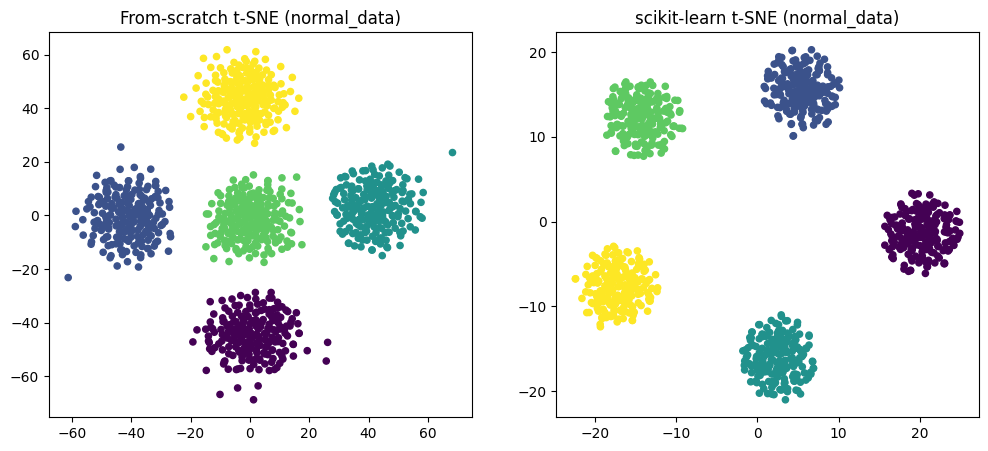

In [ ]:
###########
###TASK 2
#############

# Compute Euclidean distance matrix for normal_data
# Distances are needed if we want to run our from-scratch t-SNE with distances.
# t-SNE typically uses original features to compute P, but we can also just use distances..
X_norm = np.sum(X**2, 1, keepdims=True)
D_normal = X_norm + X_norm.T - 2 * np.dot(X, X.T)
D_normal[D_normal < 0] = 0
D_normal = np.sqrt(D_normal)

print("Running from-scratch t-SNE on normal_data...")
Y_normal = tsne_from_distance(D_normal, no_dims=2, perplexity=30.0, n_iter=500)

# Compare to scikit-learn TSNE
print("Running scikit-learn t-SNE on normal_data...")
sk_tsne = SKTSNE(n_components=2, perplexity=30, random_state=42, n_iter=500)
Y_normal_sk = sk_tsne.fit_transform(X)

# Plot results side by side
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
axes[0].scatter(Y_normal[:,0], Y_normal[:,1], c=y, cmap='viridis', s=20)
axes[0].set_title("From-scratch t-SNE (normal_data)")
axes[1].scatter(Y_normal_sk[:,0], Y_normal_sk[:,1], c=y, cmap='viridis', s=20)
axes[1].set_title("scikit-learn t-SNE (normal_data)")
plt.show()

Running from-scratch t-SNE on sequences...


C:\Users\Lorenzo\AppData\Local\Temp\ipykernel_14920\1654932281.py:17: RuntimeWarning: divide by zero encountered in log
  H = np.log(sumP) + beta_val * np.sum(distances[mask] * P) / sumP
C:\Users\Lorenzo\AppData\Local\Temp\ipykernel_14920\1654932281.py:17: RuntimeWarning: invalid value encountered in scalar divide
  H = np.log(sumP) + beta_val * np.sum(distances[mask] * P) / sumP
C:\Users\Lorenzo\AppData\Local\Temp\ipykernel_14920\1654932281.py:18: RuntimeWarning: invalid value encountered in divide
  return H, P/sumP


Iteration 100: KL divergence = 12.2981
Iteration 200: KL divergence = 12.2920
Iteration 300: KL divergence = 1.2591
Iteration 400: KL divergence = 1.2416
Iteration 500: KL divergence = 1.2415
Running scikit-learn t-SNE on sequences...


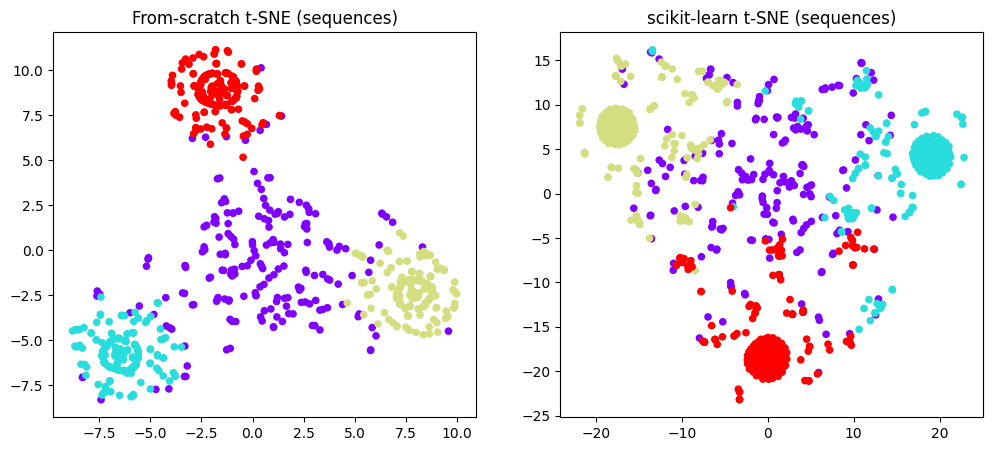

In [14]:
########################
# Task 3: Sequences Data
########################

seq_data = pd.read_csv("sequences.csv")
sequences = seq_data['sequence'].values
labels = seq_data['label'].values

# Compute Hamming distance matrix
D_seq = compute_distance_matrix(sequences)

# Run from-scratch t-SNE
print("Running from-scratch t-SNE on sequences...")
Y_seq = tsne_from_distance(D_seq, no_dims=2, perplexity=30.0, n_iter=500)

# Run scikit-learn t-SNE (I need features; here I only have sequences)
# Therefore I transform the nucleotides in integers that can be used as embeddings.
alphabet = ['A','C','G','T']
char_to_int = {ch:i for i,ch in enumerate(alphabet)}
max_len = len(sequences[0])
X_seq = np.array([[char_to_int[ch] for ch in seq] for seq in sequences]) # integer encoding

print("Running scikit-learn t-SNE on sequences...")
sk_tsne_seq = SKTSNE(n_components=2, perplexity=30, random_state=42, n_iter=500)
Y_seq_sk = sk_tsne_seq.fit_transform(X_seq)

# Plot results
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
axes[0].scatter(Y_seq[:,0], Y_seq[:,1], c=labels, cmap='rainbow', s=20)
axes[0].set_title("From-scratch t-SNE (sequences)")
axes[1].scatter(Y_seq_sk[:,0], Y_seq_sk[:,1], c=labels, cmap='rainbow', s=20)
axes[1].set_title("scikit-learn t-SNE (sequences)")
plt.show()
